## Imports

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import calendar as cld
from pandas.io import sql
from sqlalchemy import create_engine
from dateutil import parser
import geopy
from geopy.geocoders import Nominatim
from io import StringIO
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from matplotlib import pyplot

### Data Retrieval

In [3]:
# Ring Stage Data
rings = pd.read_csv('LateRing_noMotifs.csv')

# Schizont Stage Data
schizonts = pd.read_csv('LateSchizont_noMotifs.csv')

# Trophozite Stage Data
trophozites = pd.read_csv('LateTrophozoite_noMotifs.csv')


rings = rings.drop(['Unnamed: 0', 'index'], axis=1)
schizonts = schizonts.drop(['Unnamed: 0', 'index'], axis=1)
trophozites = trophozites.drop(['Unnamed: 0', 'index'], axis=1)

## Data Exploratory Ananlysis

#### We analyse the dataset here for some information about what approach to take

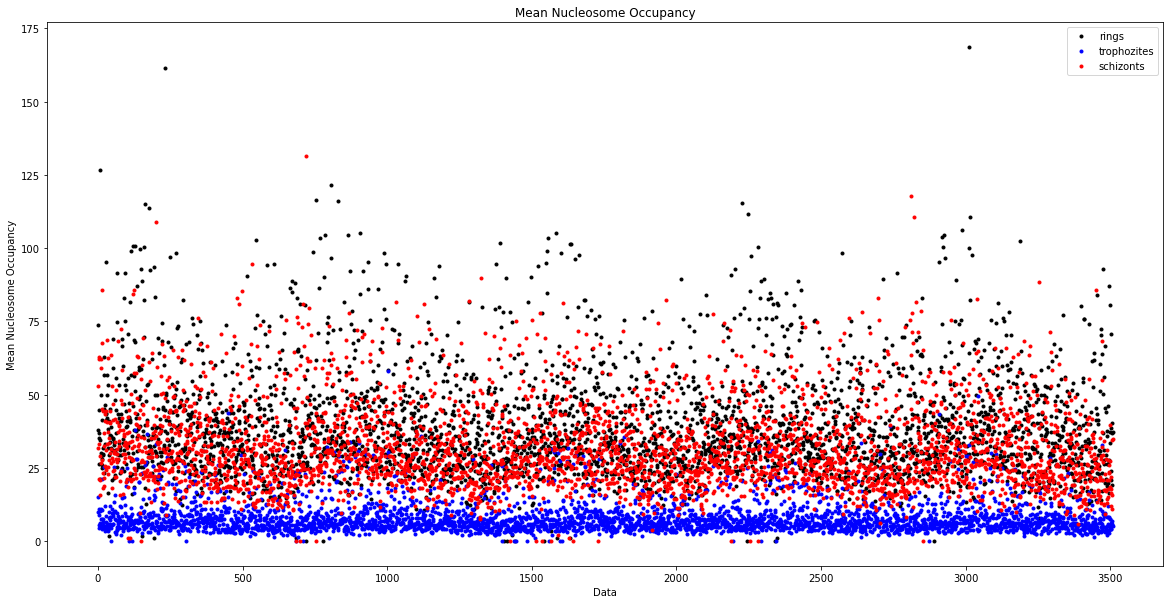

In [7]:
# Nucleosome Occupancy

Nuc_Occ = pd.DataFrame()
Nuc_Occ['rings'] = rings['Mean Nucleosome Occupancy: Gene_Body']
Nuc_Occ['trophozites'] = trophozites['Mean Nucleosome Occupancy: Gene_Body']
Nuc_Occ['schizonts'] = schizonts['Mean Nucleosome Occupancy: Gene_Body']

fig = plt.figure(figsize=(20,10))
plt.plot(Nuc_Occ['rings'], '.', color='black', label='rings')
plt.plot(Nuc_Occ['trophozites'], '.', color='blue', label='trophozites')
plt.plot(Nuc_Occ['schizonts'], '.', color='red', label='schizonts')
plt.title('Mean Nucleosome Occupancy')
plt.xlabel('Data')
plt.ylabel('Mean Nucleosome Occupancy')
plt.legend()
plt.show()

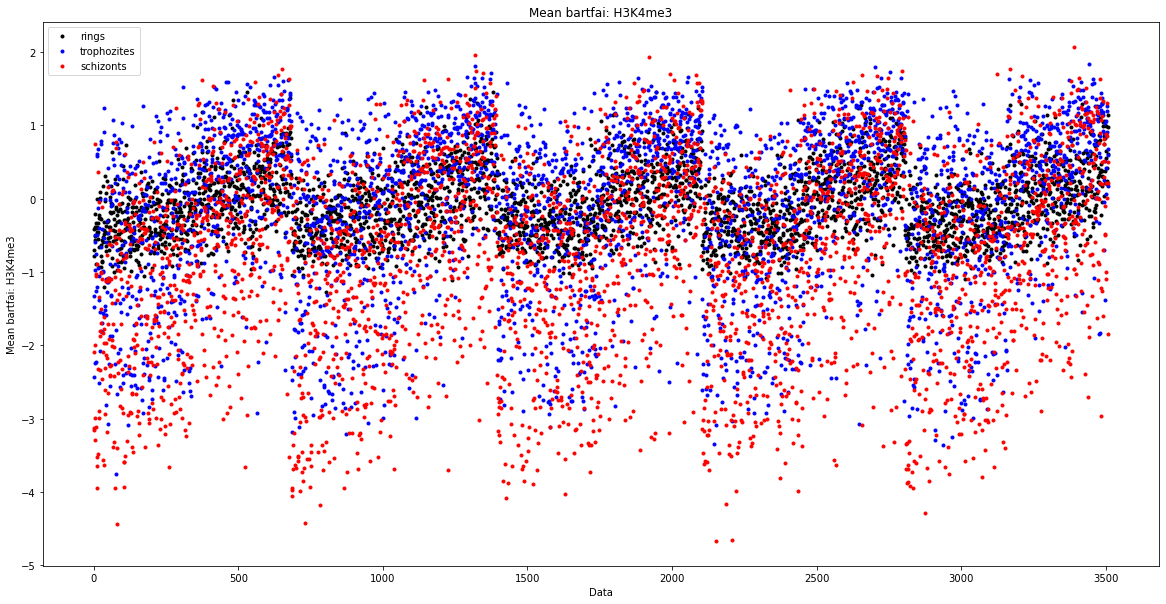

In [8]:
# H3K4me3 histone

h3k = pd.DataFrame()
h3k['rings'] = rings['Mean bartfaiH3K4me3: Gene_Body']
h3k['trophozites'] = trophozites['Mean bartfaiH3K4me3: Gene_Body']
h3k['schizonts'] = schizonts['Mean bartfaiH3K4me3: Gene_Body']

fig = plt.figure(figsize=(20,10))
plt.plot(h3k['rings'], '.', color='black', label='rings')
plt.plot(h3k['trophozites'], '.', color='blue', label='trophozites')
plt.plot(h3k['schizonts'], '.', color='red', label='schizonts')
plt.title('Mean bartfai: H3K4me3')
plt.xlabel('Data')
plt.ylabel('Mean bartfai: H3K4me3')
plt.legend()
plt.show()

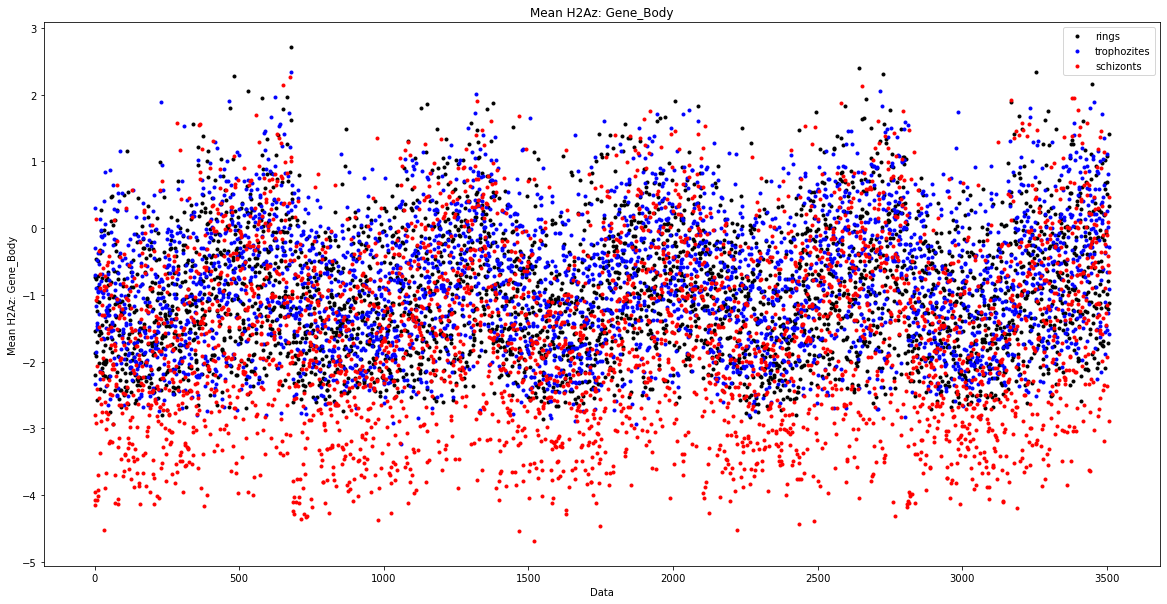

In [9]:
# H2Az body
h2k = pd.DataFrame()
h2k['rings'] = rings['Mean H2Az: Gene_Body']
h2k['trophozites'] = trophozites['Mean H2Az: Gene_Body']
h2k['schizonts'] = schizonts['Mean H2Az: Gene_Body']

fig = plt.figure(figsize=(20,10))
plt.plot(h2k['rings'], '.', color='black', label='rings')
plt.plot(h2k['trophozites'], '.', color='blue', label='trophozites')
plt.plot(h2k['schizonts'], '.', color='red', label='schizonts')
plt.title('Mean H2Az: Gene_Body')
plt.xlabel('Data')
plt.ylabel('Mean H2Az: Gene_Body')
plt.legend()
plt.show()

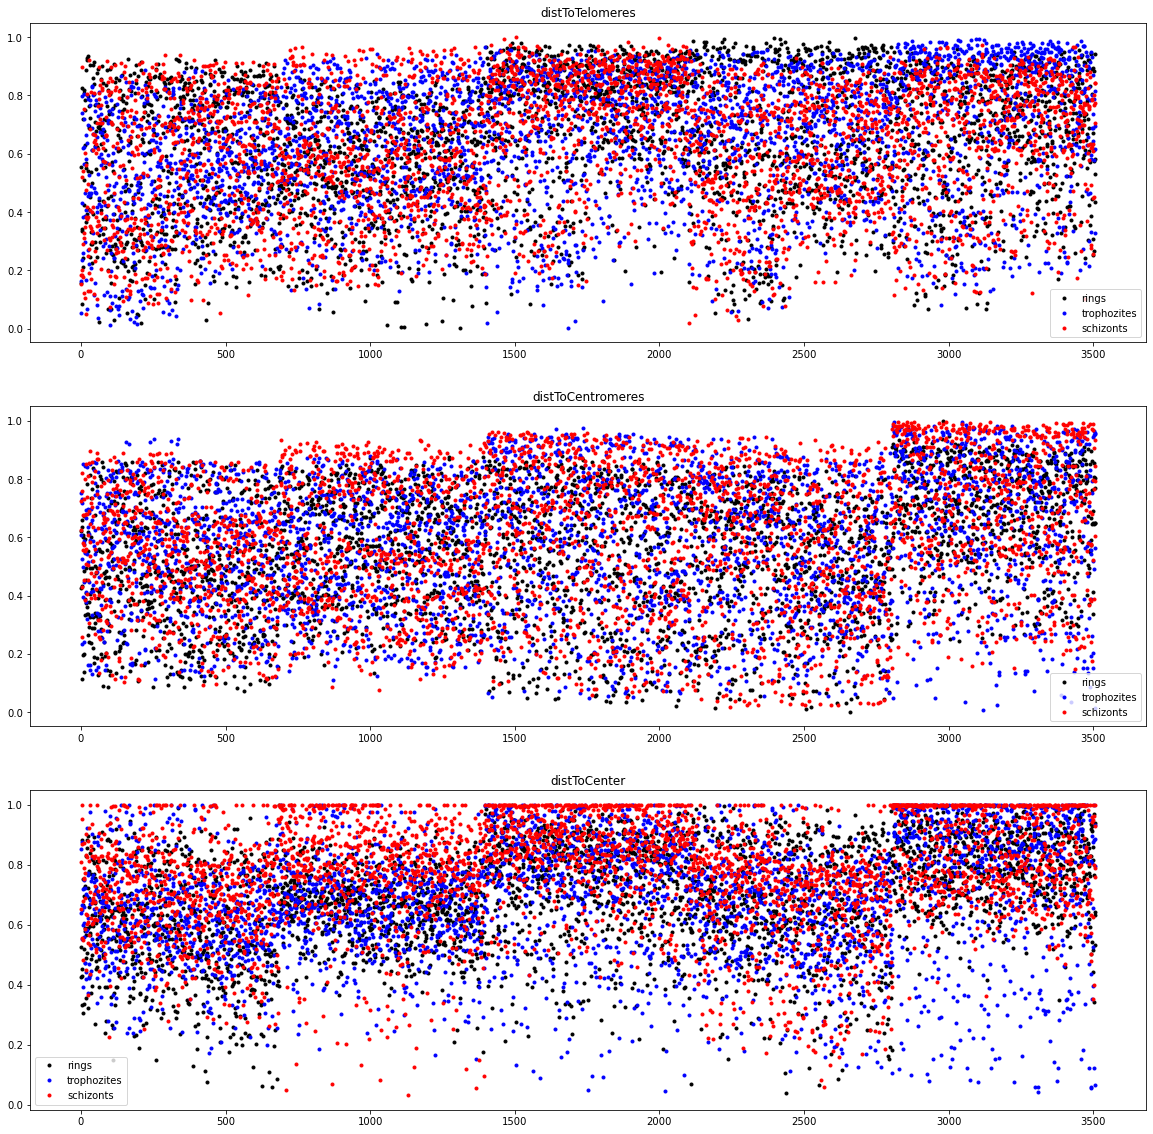

In [10]:
# 3D feature

td = pd.DataFrame()
td['rings'] = rings['distToTelomeres']
td['trophozites'] = trophozites['distToTelomeres']
td['schizonts'] = schizonts['distToTelomeres']

tc = pd.DataFrame()
tc['rings'] = rings['distToCentromeres']
tc['trophozites'] = trophozites['distToCentromeres']
tc['schizonts'] = schizonts['distToCentromeres']


c = pd.DataFrame()
c['rings'] = rings['distToCenter']
c['trophozites'] = trophozites['distToCenter']
c['schizonts'] = schizonts['distToCenter']


figure, axis = plt.subplots(3, 1, figsize=(20,20))

axis[0].plot(td['rings'], '.', color='black', label='rings')
axis[0].plot(td['trophozites'], '.', color='blue', label='trophozites')
axis[0].plot(td['schizonts'], '.', color='red', label='schizonts')
axis[0].set_title('distToTelomeres')
axis[0].legend()


axis[1].plot(tc['rings'], '.', color='black', label='rings')
axis[1].plot(tc['trophozites'], '.', color='blue', label='trophozites')
axis[1].plot(tc['schizonts'], '.', color='red', label='schizonts')
axis[1].set_title('distToCentromeres')
axis[1].legend()

axis[2].plot(c['rings'], '.', color='black', label='rings')
axis[2].plot(c['trophozites'], '.', color='blue', label='trophozites')
axis[2].plot(c['schizonts'], '.', color='red', label='schizonts')
axis[2].set_title('distToCenter')
axis[2].legend()

## Hyperparameter Tuning

In [11]:
def tune_hyperparameter(X, Y):
    
    # predefined splits
    split = [[0,684], [685,1395],
         [1396,2103],[2104,2804], [2805,3508]]
    
    running_set = [[0,1],[0,2],[1,2]]

    max_d = [4,5,6,7,8,9] #max_depth
    est = [40, 60, 80, 100] #n_estimators
    rings_acc = []

    for md in max_d:
        for e in est:
            Classifier = RandomForestClassifier(max_depth=md, random_state=42, n_estimators=e)
            sums = 0
            i = 0
            for run_set in running_set:
                test_id = run_set[0]
                train_id = run_set[1]
        
                test_split_n, test_split_m = split[test_id][0], split[test_id][1]
                train_split_n, train_split_m = split[train_id][0], split[train_id][1]
        
                X_train_split = X[train_split_n:train_split_m]
                Y_train_split = Y[train_split_n:train_split_m]
                X_test_split = X[test_split_n:test_split_m]
                Y_test_split = Y[test_split_n:test_split_m]
        
                Classifier.fit(X_train_split, Y_train_split)
                predictions = Classifier.predict(X_test_split)
                acs = accuracy_score(predictions, Y_test_split)
                sums = sums + acs
                i = i + 1
            
            avg_acc = sums/i
            rings_acc.append([md, e, avg_acc])

    column_names = ['max_depth', 'n_estimators','Score']
    fin_r = pd.DataFrame(rings_acc, columns=column_names)
    r = fin_r.sort_values(by=['Score'], ascending=False)
    r = r.iloc[0]
    return r['max_depth'], r['n_estimators']

rings_acc = []

X = rings.loc[:, rings.columns != 'Response']
Y = rings[['Response']]
Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
rings_dep, rings_est = tune_hyperparameter(X, Y)

X = trophozites.loc[:, trophozites.columns != 'Response']
Y = rings[['Response']]
Y['Response'] = pd.Series(np.where(trophozites.Response.values == 'High', 1, 0), trophozites.index)
trophozites_dep, trophozites_est = tune_hyperparameter(X, Y)

X = schizonts.loc[:, schizonts.columns != 'Response']
Y = schizonts[['Response']]
Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index)
schizonts_dep, schizonts_est = tune_hyperparameter(X, Y)


print('RING')
print(rings_dep, rings_est)
print('TROPHOZITES')
print(trophozites_dep, trophozites_est)
print('SCHIZONT')
print(schizonts_dep, schizonts_est)

<ipython-input-11-bc8521e0c527>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was ex

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversi

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversi

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversi

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversi

<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-11-bc8521e0c527>:30: DataConversi

RING
8.0 40.0
TROPHOZITES
9.0 60.0
SCHIZONT
7.0 100.0


## Feature Selection

In [14]:
def create_accuracy_feature(stage, feature, X, Y, md, est):
    split = [[0,684], 
         [685,1395],
         [1396,2103],
         [2104,2804],
         [2805,3508]]
    
    chrom_set = ['6,8,10','4,5,12',
          '1,3,13','2,9,11','7,14']
    
    running_set = [[0,2],[0,3],[0,4],
               [1,2],[1,3],[1,4]]

    #model
    Classifier = RandomForestClassifier(max_depth=md, random_state=42, n_estimators=est)
    
    sums = []
    for run_set in running_set:
        test_id = run_set[0]
        train_id = run_set[1]
        
        test_split_n, test_split_m = split[test_id][0], split[test_id][1]
        train_split_n, train_split_m = split[train_id][0], split[train_id][1]
        
        X_train_split = X[train_split_n:train_split_m]
        Y_train_split = Y[train_split_n:train_split_m]
        X_test_split = X[test_split_n:test_split_m]
        Y_test_split = Y[test_split_n:test_split_m]
        
        Classifier.fit(X_train_split, Y_train_split)
        predictions = Classifier.predict(X_test_split)
        acs = accuracy_score(predictions, Y_test_split)
                
        sums.append(acs)
        
    avg_accs = max(sums)
    
    return stage, feature, avg_accs

column_names = ['Stage', 'Feature', 'Accuracy']
accs = []

X = rings.loc[:, rings.columns != 'Response']
Y = rings[['Response']]
for cols in X.columns:
    X_miss = X.loc[:, X.columns != cols]
    accs.append(create_accuracy_feature('Ring', cols, X_miss, Y, 8, 40))

X = trophozites.loc[:, trophozites.columns != 'Response']
Y = trophozites[['Response']]
for cols in X.columns:
    X_miss = X.loc[:, X.columns != cols]
    accs.append(create_accuracy_feature('Trophozite', cols, X_miss, Y, 9, 60))

X = schizonts.loc[:, schizonts.columns != 'Response']
Y = schizonts[['Response']]
for cols in X.columns:
    X_miss = X.loc[:, X.columns != cols]
    accs.append(create_accuracy_feature('Schizont', cols, X_miss, Y, 7, 100))
    
fin = pd.DataFrame(accs, columns=column_names)

#Saving the data to file for further use
fin.to_csv('analysis.csv')

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-14-3d987c0c9837>:30: DataConversi

## Running the final model with tuned hyperparameters

In [15]:
def each_feature(feature, X,Y, md, est):
    split = [[0,684], [685,1395],
         [1396,2103],[2104,2804], [2805,3508]]
    running_set = [[0,1],[0,2],[1,2]]
    
    Classifier = RandomForestClassifier(max_depth=md, random_state=42, n_estimators=est)
    sums = 0
    fpr_sums = 0
    tpr_sums = 0
    i = 0
    for run_set in running_set:
        test_id = run_set[0]
        train_id = run_set[1]
        
        test_split_n, test_split_m = split[test_id][0], split[test_id][1]
        train_split_n, train_split_m = split[train_id][0], split[train_id][1]
        
        X_train_split = X[train_split_n:train_split_m]
        Y_train_split = Y[train_split_n:train_split_m]
        X_test_split = X[test_split_n:test_split_m]
        Y_test_split = Y[test_split_n:test_split_m]
        
        Classifier.fit(X_train_split, Y_train_split)
        predictions = Classifier.predict(X_test_split)
        acs = accuracy_score(predictions, Y_test_split)
        fpr, tpr, thresholds = metrics.roc_curve(predictions, Y_test_split)
        sums = sums + acs
        fpr_sums = fpr_sums + fpr[1]
        tpr_sums = tpr_sums + tpr[1]
        i = i + 1
    avg_acc = sums/i
    avg_fpr = fpr_sums/i
    avg_tpr = tpr_sums/i
    
    return feature, avg_acc, avg_fpr, avg_tpr

column_names = ['Feature', 'Accuracy', 'FPR', 'TPR']
X = rings.loc[:, rings.columns != 'Response']
col = X.columns
rings_solo = []
for name in col:
    x = X[[name]]
    Y = rings[['Response']]
    Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index) 
    rings_solo.append(each_feature(name, x, Y, 8, 40))
ring_single = pd.DataFrame(rings_solo, columns=column_names)


column_names = ['Feature', 'Accuracy', 'FPR', 'TPR']
X = trophozites.loc[:, trophozites.columns != 'Response']
col = X.columns
trophozites_solo = []
for name in col:
    x = X[[name]]
    Y = trophozites[['Response']]
    Y['Response'] = pd.Series(np.where(trophozites.Response.values == 'High', 1, 0), trophozites.index) 
    trophozites_solo.append(each_feature(name, x, Y, 9, 60))
trophozites_single = pd.DataFrame(trophozites_solo, columns=column_names)


column_names = ['Feature', 'Accuracy', 'FPR', 'TPR']
X = schizonts.loc[:, schizonts.columns != 'Response']
col = X.columns
schizonts_solo = []
for name in col:
    x = X[[name]]
    Y = schizonts[['Response']]
    Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index) 
    schizonts_solo.append(each_feature(name, x, Y, 7, 100))
schizonts_single = pd.DataFrame(schizonts_solo, columns=column_names)

<ipython-input-15-11a950297e49>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was ex

<ipython-input-15-11a950297e49>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was ex

<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was ex

<ipython-input-15-11a950297e49>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(trophozites.Response.values == 'High', 1, 0), trophozites.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d 

<ipython-input-15-11a950297e49>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(trophozites.Response.values == 'High', 1, 0), trophozites.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d 

<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d arra

<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d arra

<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-15-11a950297e49>:23: DataConversionWarning: A column-vector y was passed when a 1d arra

In [18]:
def create_accuracy(stage, X, Y, md, est):
    split = [[0,684], 
         [685,1395],
         [1396,2103],
         [2104,2804],
         [2805,3508]]
    
    chrom_set = ['6,8,10','4,5,12',
          '1,3,13','2,9,11','7,14']
    
    running_set = [[0,2],[0,3],[0,4],
               [1,2],[1,3],[1,4]]

    Classifier = RandomForestClassifier(max_depth=md, random_state=42, n_estimators=est)
    
    sums = 0
    fpr_sums = 0
    tpr_sums = 0
    auc_sums = 0
    i = 0
    for run_set in running_set:
        test_id = run_set[0]
        train_id = run_set[1]
        
        test_split_n, test_split_m = split[test_id][0], split[test_id][1]
        train_split_n, train_split_m = split[train_id][0], split[train_id][1]
        
        X_train_split = X[train_split_n:train_split_m]
        Y_train_split = Y[train_split_n:train_split_m]
        X_test_split = X[test_split_n:test_split_m]
        Y_test_split = Y[test_split_n:test_split_m]
        
        Classifier.fit(X_train_split, Y_train_split)
        predictions = Classifier.predict(X_test_split)
        acs = accuracy_score(predictions, Y_test_split)
        fpr, tpr, thresholds = metrics.roc_curve(predictions, Y_test_split)
        auc = metrics.auc(fpr, tpr)
        
        sums = sums + acs
        fpr_sums = fpr_sums + fpr[1]
        tpr_sums = tpr_sums + tpr[1]
        auc_sums = auc_sums + auc
        i = i + 1

        
    avg_accs = sums/i
    
    avg_fpr = fpr_sums/i
    avg_tpr = tpr_sums/i
    avg_auc = auc_sums/i
    return stage, avg_accs, avg_fpr, avg_tpr , avg_auc

column_names = ['Stage', 'Accuracy', 'FPR', 'TPR', 'AUC']
rings_acc = []
trophozites_acc = []
schizonts_acc = []

X = rings.loc[:, rings.columns != 'Response']
Y = rings[['Response']]
Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
rings_acc.append(create_accuracy('Ring',X, Y, 8, 40))

X = trophozites.loc[:, trophozites.columns != 'Response']
Y = trophozites[['Response']]
Y['Response'] = pd.Series(np.where(trophozites.Response.values == 'High', 1, 0), trophozites.index)
trophozites_acc.append(create_accuracy('Trophozites',X, Y, 9, 60))

X = schizonts.loc[:, schizonts.columns != 'Response']
Y = schizonts[['Response']]
Y['Response'] = pd.Series(np.where(schizonts.Response.values == 'High', 1, 0), schizonts.index)
schizonts_acc.append(create_accuracy('Schizonts',X, Y, 7, 100))


fin_r = pd.DataFrame(rings_acc, columns=column_names)
fin_t = pd.DataFrame(trophozites_acc, columns=column_names)
fin_s = pd.DataFrame(schizonts_acc, columns=column_names)

<ipython-input-18-07f0b59f02af>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Response'] = pd.Series(np.where(rings.Response.values == 'High', 1, 0), rings.index)
<ipython-input-18-07f0b59f02af>:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-18-07f0b59f02af>:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Classifier.fit(X_train_split, Y_train_split)
<ipython-input-18-07f0b59f02af>:33: DataConversionWarning: A column-vector y was passed when a 1d array was ex

## Plotting AUC curves

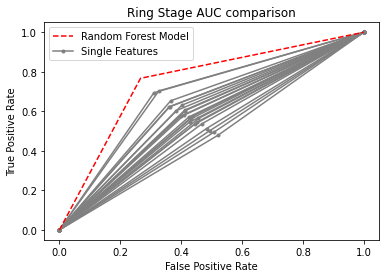

In [19]:
for feature,FPR,TPR in zip(ring_single['Feature'],ring_single['FPR'],ring_single['TPR']):
    fpr = [0, FPR, 1]
    tpr = [0, TPR, 1]
    pyplot.plot(fpr, tpr, marker='.',color='grey')

    
fpr_t = [0, fin_r['FPR'][0], 1]
tpr_t = [0, fin_r['TPR'][0], 1]
pyplot.plot(fpr_t, tpr_t, linestyle='--',color='red', label='Random Forest Model')
pyplot.plot([], [], marker='.', color='grey', label="Single Features")

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('Ring Stage AUC comparison')
pyplot.show()

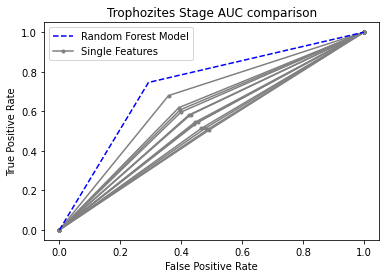

In [20]:
for feature,FPR,TPR in zip(trophozites_single['Feature'],trophozites_single['FPR'],trophozites_single['TPR']):
    fpr = [0, FPR, 1]
    tpr = [0, TPR, 1]
    pyplot.plot(fpr, tpr, marker='.',color='grey')

    
fpr_t = [0, fin_t['FPR'][0], 1]
tpr_t = [0, fin_t['TPR'][0], 1]
pyplot.plot(fpr_t, tpr_t, linestyle='--',color='blue', label='Random Forest Model')
pyplot.plot([], [], marker='.', color='grey', label="Single Features")    
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('Trophozites Stage AUC comparison')
pyplot.show()

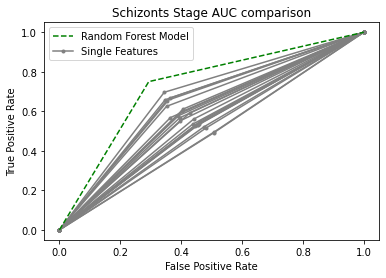

In [21]:
for feature,FPR,TPR in zip(schizonts_single['Feature'],schizonts_single['FPR'],schizonts_single['TPR']):
    fpr = [0, FPR, 1]
    tpr = [0, TPR, 1]
    pyplot.plot(fpr, tpr, marker='.',color='grey')

    
fpr_t = [0, fin_s['FPR'][0], 1]
tpr_t = [0, fin_s['TPR'][0], 1]
pyplot.plot(fpr_t, tpr_t, linestyle='--',color='green', label='Random Forest Model')
pyplot.plot([], [], marker='.', color='grey', label="Single Features")    
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('Schizonts Stage AUC comparison')
pyplot.show()